# Clustering

<img src="../images/kmeans.png" alt="" width="600"/>

Clustering is the process of examining a collection of "points" and grouping the points into "clusters" according to some **distance measure**. The goal is that the points in the same cluster have a small distance from one another, while points in different clusters are at a larger distance from one another.

### Points, Spaces, and Distances
A dataset suitable for clustering is a collection of _points_, which are just objects belonging to some _space_. In its most general sense, a space is just a universal set of points, from which the points in the dataset are drawn. All spaces for which we can perform a clustering have a distance measure, giving a distance between any two points in the space.

In [1]:
# Import pandas
import pandas as pd
pd.set_option('display.max_columns', None)

# Import seaborn
import seaborn as sns
%matplotlib inline

# Apply the default theme
sns.set_theme()

## K-Means Algorithm (Step-by-step)
K-Means is the best known algorithm in a family of clustering algorithms known as _point-assignment algorithms_. K-Means requires a Euclidean space and assumes the number of clusters, _k_, is known in advance. It is, however, possible to deduce _k_ by trial and error. 

In order to explain the K-Means algorithm, we will start by creating a low dimension "demo" dataset that has a clear number of clusters (K=2)

In [2]:
# create demo data
points = [
    [2.5, 1.1],
    [1.5, 2],
    [2, 3],
    [4, 6],
    [4, 4],
    [4.5, 5],
    [3.5, 5.1]
]
points

[[2.5, 1.1], [1.5, 2], [2, 3], [4, 6], [4, 4], [4.5, 5], [3.5, 5.1]]

In [3]:
# identify columns and index
columns = ["x", "y"]
index = [f"P-{i}" for i in range(len(points))]

# create data frame
demodf = pd.DataFrame(
    points, 
    columns=columns, 
    index=index
)

# add blank label column
demodf['cluster'] = 'N/A'

# display demo data
demodf

,x,y,cluster
P-0,2.5,1.1,N/A
P-1,1.5,2.0,N/A
P-2,2.0,3.0,N/A
P-3,4.0,6.0,N/A
P-4,4.0,4.0,N/A
P-5,4.5,5.0,N/A
P-6,3.5,5.1,N/A


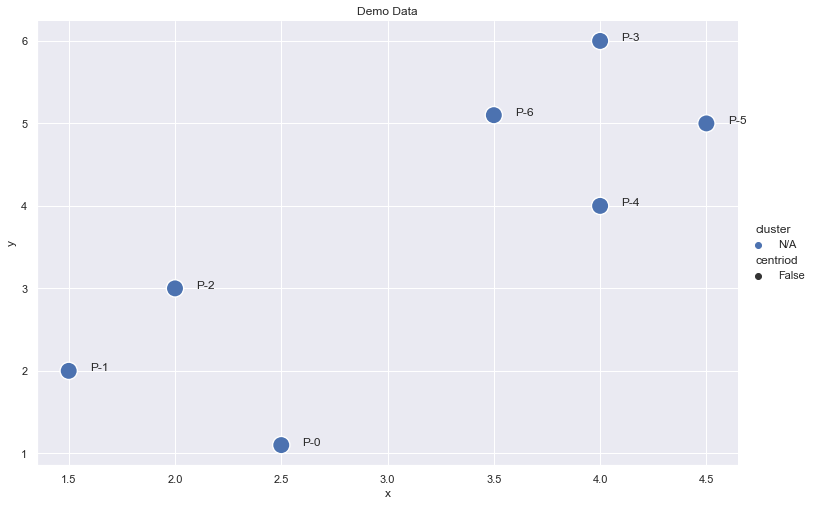

In [4]:
def kmeans_plot(df, cf=None):
    
    df_tmp = df.copy()
    df_tmp['centriod'] = False
    
    if cf is not None:
        cf_tmp = cf.copy()
        cf_tmp['centriod'] = True
    
    vf = pd.concat([df_tmp, cf_tmp]) if cf is not None else df_tmp
    
    # visualize demo + centriod data
    scatter = sns.relplot(
        data=vf, 
        x="x", 
        y="y",
        hue='cluster',
        style='centriod',
        kind="scatter",
        height=7,
        aspect=1.5,
        s=300
    ).set(
        title="Demo Data"
    )

    # label points with index
    for i, point in vf.iterrows():
        scatter.ax.text(point['x']+.1, point['y'], i)
        
kmeans_plot(demodf)

### Step 1
* Pick K value (how many clusters you want)
* Choose initial centriods from points (can be random for larger data. here we pick two obivous candidates)

In [5]:
k=2

initial_centriods = [ 
    [2.5, 1.1, 'C-1'],  # P-0
    [3.5, 5.1, 'C-2'],  # P-6
]

centriods = pd.DataFrame(
    initial_centriods, 
    columns=['x', 'y', 'cluster'],
    index=['C-1', 'C-2']
)

centriods

,x,y,cluster
C-1,2.5,1.1,C-1
C-2,3.5,5.1,C-2


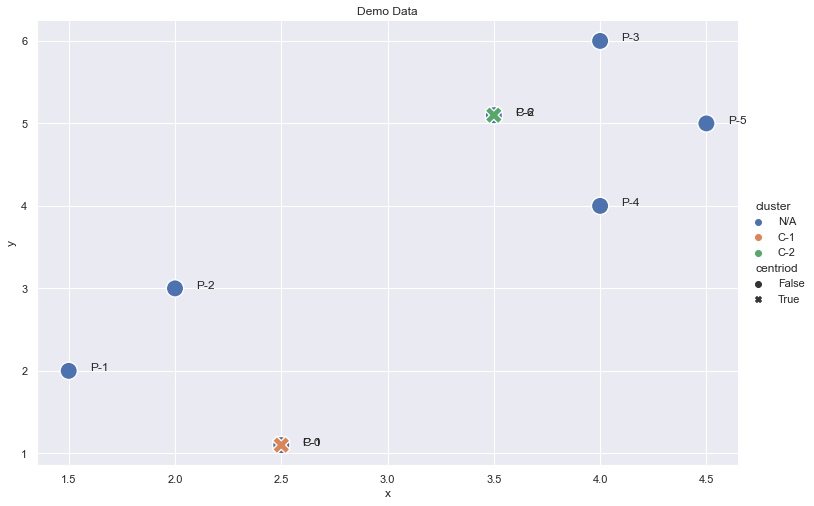

In [6]:
kmeans_plot(demodf, centriods)

### Step 2
* Determine the centriod closest to each point
* Assign the point to a cluster

Let's use the $\textit{L}_{1}\textit{-norm}$, or $\textit{Manhattan distance}$. 

<br />

$$
d([x_{1},x_{2},...,x_{n}], [y_{1},y_{2},...,y_{n}]) = \sum_{i=1}^{n} |x_{i} - y_{i}|
\\
$$

<br />

In [7]:
# 2D array of points
points = demodf[['x', 'y']].values

In [8]:
# demodf[['x', 'y']].values

In [9]:
# point of C-1
c_1 = centriods.loc['C-1'].values[:2]

In [10]:
# point of C-2
c_2 = centriods.loc['C-2'].values[:2]

In [11]:
def manhattan_distance(a, c):
    dist = []
    for row in a:
        x_dist = abs(row[0] - c[0])
        y_dist = abs(row[1] - c[1])
        dist.append(x_dist + y_dist)
        
    return dist

In [12]:
demodf['C-1'] = manhattan_distance(points, c_1)
demodf['C-2'] = manhattan_distance(points, c_2)

In [13]:
demodf

,x,y,cluster,C-1,C-2
P-0,2.5,1.1,N/A,0.0,5.0
P-1,1.5,2.0,N/A,1.9,5.1
P-2,2.0,3.0,N/A,2.4,3.6
P-3,4.0,6.0,N/A,6.4,1.4
P-4,4.0,4.0,N/A,4.4,1.6
P-5,4.5,5.0,N/A,5.9,1.1
P-6,3.5,5.1,N/A,5.0,0.0


In [14]:
def label_cluster(row):
    if row['C-1'] < row['C-2']:
        return 'C-1'
    return 'C-2'

demodf['cluster'] = demodf.apply(label_cluster, axis=1)

In [15]:
demodf

,x,y,cluster,C-1,C-2
P-0,2.5,1.1,C-1,0.0,5.0
P-1,1.5,2.0,C-1,1.9,5.1
P-2,2.0,3.0,C-1,2.4,3.6
P-3,4.0,6.0,C-2,6.4,1.4
P-4,4.0,4.0,C-2,4.4,1.6
P-5,4.5,5.0,C-2,5.9,1.1
P-6,3.5,5.1,C-2,5.0,0.0


### K-Means Algorithm Step 3
* Update centriod position
* Repeat procedure until convergence

In [16]:
centriods

,x,y,cluster
C-1,2.5,1.1,C-1
C-2,3.5,5.1,C-2


In [17]:
demodf[demodf['cluster'] == 'C-1'][['x', 'y']].mean()

x    2.000000
y    2.033333
dtype: float64

In [18]:
new_center_1 = demodf[ demodf['cluster'] == 'C-1' ][['x', 'y']].mean()
new_center_1

x    2.000000
y    2.033333
dtype: float64

In [19]:
centriods.loc['C-1', 'x'] = new_center_1[0]
centriods.loc['C-1', 'y'] = new_center_1[1]

In [20]:
new_center_2 = demodf[ demodf['cluster'] == 'C-2' ][['x', 'y']].mean()
centriods.loc['C-2', 'x'] = new_center_2[0]
centriods.loc['C-2', 'y'] = new_center_2[1]

In [21]:
centriods

,x,y,cluster
C-1,2.0,2.033333,C-1
C-2,4.0,5.025000,C-2


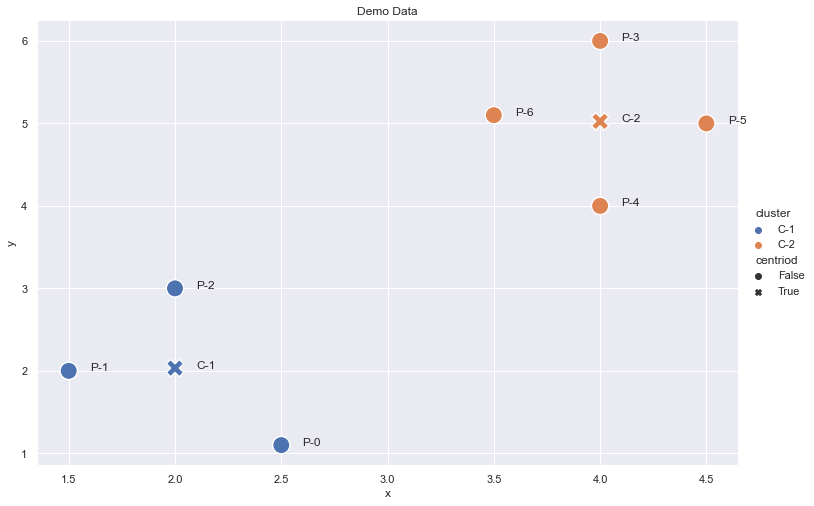

In [22]:
kmeans_plot(demodf, centriods)

## K-Means Algorithm (scikit-learn)
https://scikit-learn.org/stable/index.html

In [23]:
from sklearn.datasets import make_blobs

# create dataset https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
blobs, _ = make_blobs(
    n_samples=150, 
    n_features=2,
    centers=3, 
    cluster_std=0.5,
    shuffle=True, 
    random_state=0
)

type(blobs)

numpy.ndarray

In [24]:
# print the first five points
blobs[:5]

array([[2.60509732, 1.22529553],
       [0.5323772 , 3.31338909],
       [0.802314  , 4.38196181],
       [0.5285368 , 4.49723858],
       [2.61858548, 0.35769791]])

### Create DataFrame from 2d ndarray
This step is not strictly necessary (in fact, we'll just use the 2D ndarray for fitting our model). Converting to a DataFrame allows us to use our pandas and seaborn knowledge.

In [25]:
blobs_df = pd.DataFrame(blobs, columns=['x', 'y'])

In [26]:
blobs_df.head()

,x,y
0,2.605097,1.225296
1,0.532377,3.313389
2,0.802314,4.381962
3,0.528537,4.497239
4,2.618585,0.357698


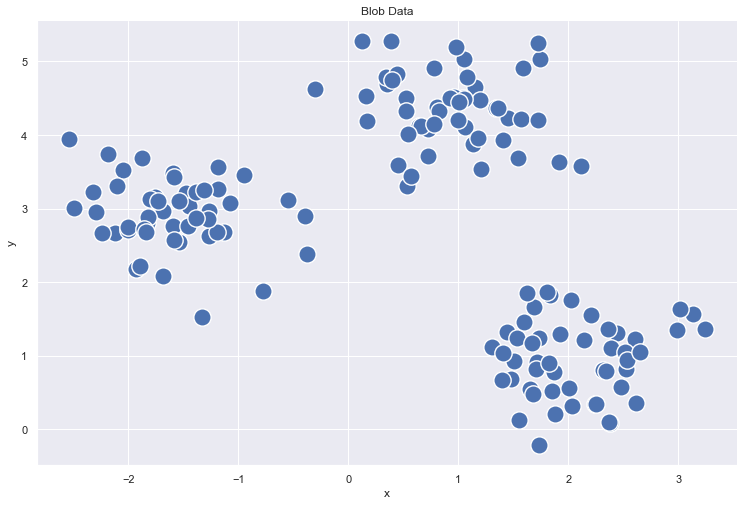

In [27]:
scatter = sns.relplot(
    data=blobs_df, 
        x="x", 
        y="y",
        kind="scatter",
        height=7,
        aspect=1.5,
        s=300
    ).set(
        title="Blob Data"
    )

### Working with sklearn.cluster.KMeans

In [28]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans

In [29]:
km = KMeans(
    n_clusters = 3, 
)

km

KMeans(n_clusters=3)

In [30]:
result = km.fit(blobs)

In [31]:
result.cluster_centers_

array([[ 2.06521743,  0.96137409],
       [-1.5947298 ,  2.92236966],
       [ 0.9329651 ,  4.35420712]])

In [32]:
result.labels_

array([0, 2, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 2, 1, 1, 0, 1, 0, 2, 0,
       2, 2, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 2, 2, 1, 1, 2, 0,
       0, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 1,
       2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2, 0, 0, 2, 2, 0, 0, 0, 1,
       1, 0, 0, 2, 0, 2, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 2, 2,
       1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 2, 1, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 0, 0], dtype=int32)

In [33]:
# assign the newly minted cluster labels to the DataFrame we creaed earlier
blobs_df["cluster"] = pd.Series(result.labels_).astype("str")

In [34]:
blobs_df.head()

,x,y,cluster
0,2.605097,1.225296,0
1,0.532377,3.313389,2
2,0.802314,4.381962,2
3,0.528537,4.497239,2
4,2.618585,0.357698,0


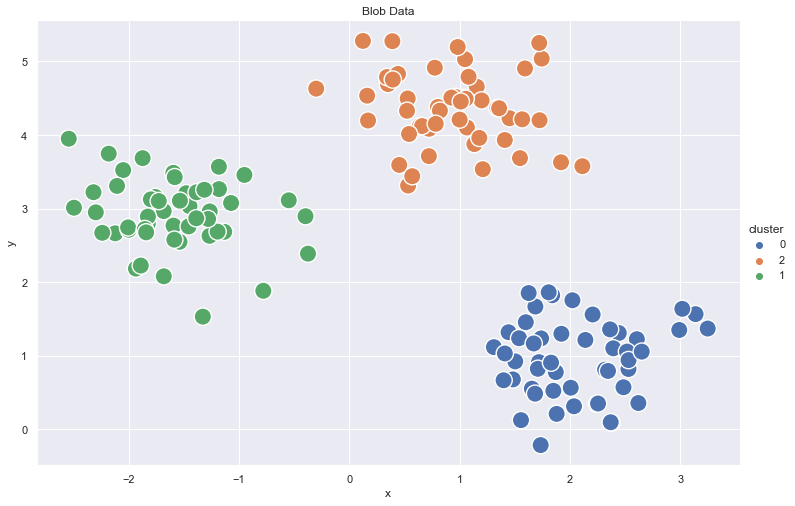

In [35]:
scatter = sns.relplot(
    data=blobs_df, 
    x="x", 
    y="y",
    hue="cluster",   # color by cluster
    kind="scatter",
    height=7,
    aspect=1.5,
    s=300
).set(
    title="Blob Data"
)

## Picking the Right Value of _k_
We may not know the correct value of _k_ to use in a k-means clustering. However, if we can measure the quality of the clustering for variouss values of _k_, we can usually guess what the right value of _k_ is. If we take a measure of appropriateness for clusters, such as average radius or diameter, we expect that value will grow slowly as long as the number of clusters remains at or above the true number of clusters. However, as soon as we try to form fewer clusters than there really are, the measure will rise precipitously. 

The K-Means algorithm aims to choose centroids that minimize the _inertia_, or within-cluster sum-of-squares. We want to choose a value of _k_ that also minimizes _inertia_, but not at the expense of choosing an unnaturally large number of clusters. _Inertia_ can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:

* Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.

* Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”).

In [36]:
result.inertia_

72.47601670996697

In [37]:
dist = []
dfs = []
for i in range(1, 8):
    km = KMeans(n_clusters = i, init="random",
           n_init = 10, max_iter=300,
           tol=1e-04, random_state=0)
    result = km.fit(blobs)
    
    dist.append(result.inertia_)
    
    blobs_df["cluster"] = pd.Series(result.labels_).astype("str")
    dfs.append(blobs_df.copy())

In [38]:
idf = pd.DataFrame({
    "k":range(1, 8),
    "distortion":dist
})

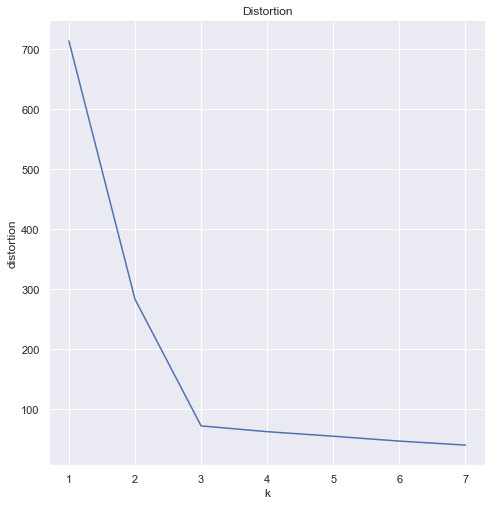

In [39]:
scatter = sns.relplot(
    data=idf, 
    x="k", 
    y="distortion",
    kind="line",
    height=7,
).set(
    title="Distortion"
)

In [40]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
for idx, df in enumerate(dfs, 1):

    scatter = sns.relplot(
        data=df, 
        x="x", 
        y="y",
        hue="cluster",   # color by cluster
        kind="scatter",
        height=7,
        aspect=1.5,
        s=300
    ).set(
        title=f"Blob Data ({idx})"
    )